# 1. Check Setup environments

In [1]:
import sys, os, distutils.core

In [2]:
!nvidia-smi

Wed Sep 27 07:31:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   24C    P0    24W / 250W |      0MiB / 12288MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!conda env list

# conda environments:
#
VAdepthENV               /home/013907062/.conda/envs/VAdepthENV
cmpe249               *  /home/013907062/.conda/envs/cmpe249
env_onmttf               /home/013907062/.conda/envs/env_onmttf
koen_base                /home/013907062/.conda/envs/koen_base
newDepth                 /home/013907062/.conda/envs/newDepth
test                     /home/013907062/.conda/envs/test
wmt_infer                /home/013907062/.conda/envs/wmt_infer
base                     /opt/ohpc/pub/apps/anaconda/3.9
stylegan2                /opt/ohpc/pub/apps/anaconda/3.9/envs/stylegan2



In [3]:
!pip list | grep torch

torch                         2.0.1
torchaudio                    2.0.2
torchinfo                     1.8.0
torchvision                   0.15.2


In [4]:
!nvcc --version

/bin/bash: nvcc: command not found


In [4]:
try:
    import detectron2
    import torch
    import torchvision
    print(f"detectron2 version: {detectron2.__version__}")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

detectron2 version: 0.6
torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from PIL import Image
import matplotlib.pyplot as plt

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [6]:
!pwd

/home/013907062/CMPE249/HW1_waymo


# 2. Preparing Dataset as COCO format

In [21]:
import json
import os
from PIL import Image

def YoloFormatConvertToCOCOJson(input_dir, anno_dir, output_dir, output_file_name, categories):
    # Define the COCO dataset dictionary
    coco_dataset = {
        "info": {},
        "licenses": [],
        "categories": categories,
        "images": [],
        "annotations": []
    }
    
    # Loop through the images in the input directory
    for image_file in os.listdir(input_dir):
        # Load the image and get its dimensions
        image_path = os.path.join(input_dir, image_file)
        image = Image.open(image_path)
        width, height = image.size
        
        # Add the image to the COCO dataset
        image_dict = {
            "id": int(image_file.split('.')[0]),
            "width": width,
            "height": height,
            "file_name": image_file
        }
        coco_dataset["images"].append(image_dict)
        
        # Load the bounding box annotations for the image
        with open(os.path.join(anno_dir, f'{image_file.split(".")[0]}.txt')) as f:
            annotations = f.readlines()
        
        # Loop through the annotations and add them to the COCO dataset
        for ann in annotations:
            #x, y, w, h = map(float, ann.strip().split()[1:])
            label, x, y, w, h = map(float, ann.strip().split())
            x_min, y_min = int((x - w / 2) * width), int((y - h / 2) * height)
            x_max, y_max = int((x + w / 2) * width), int((y + h / 2) * height)
            ann_dict = {
                "id": len(coco_dataset["annotations"]),
                "image_id": int(image_file.split('.')[0]),
                "category_id": int(ann.strip().split()[0]), 
                "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                "area": (x_max - x_min) * (y_max - y_min),
                "iscrowd": 0
            }
            coco_dataset["annotations"].append(ann_dict)
    
    # Save the COCO dataset to a JSON file
    #with open(os.path.join(output_dir, 'train_annotations.json'), 'w') as f:
    with open(os.path.join(output_dir, output_file_name), 'w') as f:
        json.dump(coco_dataset, f)

In [22]:
# Define the categories for the COCO dataset
categories = [{"id": 0, "name": "vehicle"},{"id": 1, "name": "pedestrian"},{"id": 2, "name": "sign"},{"id": 3, "name": "cyclist"}]
#convert
YoloFormatConvertToCOCOJson('./dataset/train/images', './dataset/train/labels', './coco_annotation', 'train_annotations.json', categories)
YoloFormatConvertToCOCOJson('./dataset/valid/images', './dataset/valid/labels', './coco_annotation', 'valid_annotations.json', categories)
YoloFormatConvertToCOCOJson('./dataset/test/images', './dataset/test/labels', './coco_annotation', 'test_annotations.json', categories)

# 3. Train with Waymo partial dataset

## 3.1 Waymo Partial Dataset Register and visualization with train dataset

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coco_waymo_train", {}, "./coco_annotation/train_annotations.json", "./dataset/train/images/")
register_coco_instances("coco_waymo_valid", {}, "./coco_annotation/valid_annotations.json", "./dataset/valid/images/")
register_coco_instances("coco_waymo_test", {}, "./coco_annotation/test_annotations.json", "./dataset/test/images/")

[09/27 07:32:00 d2.data.datasets.coco]: Loaded 1001 images in COCO format from ./coco_annotation/train_annotations.json
./dataset/train/images/148510.jpg


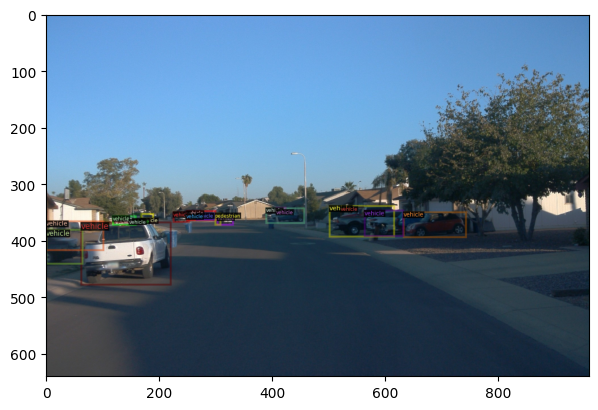

./dataset/train/images/074495.jpg


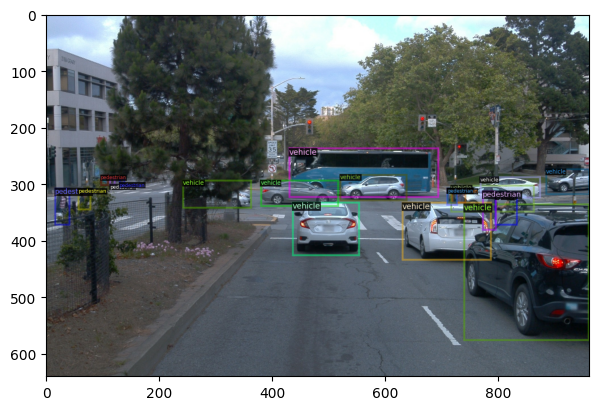

./dataset/train/images/193193.jpg


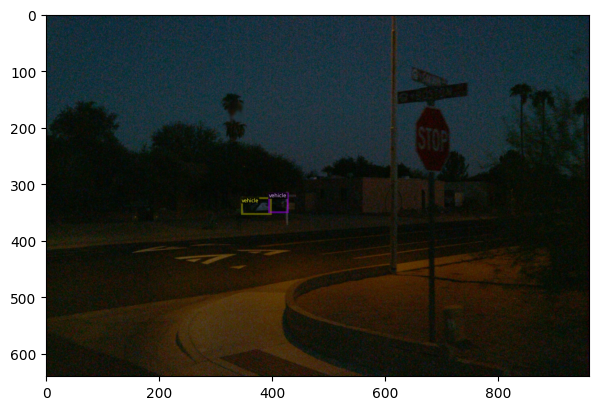

In [8]:
#visualize training data
coco_waymo_train_metadata = MetadataCatalog.get("coco_waymo_train")
dataset_dicts = DatasetCatalog.get("coco_waymo_train")

import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coco_waymo_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (7, 10))
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## 2.2 Retrain/Resume: Detectron2 Object Detection

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.structures import BoxMode

In [10]:
def get_my_cfg():
    cfg = get_cfg()
    cfg.DATALOADER.NUM_WORKERS = 8
    #for detection
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    #Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl
    cfg.MODEL.WEIGHTS = 'model_final_68b088.pkl'
    cfg.DATASETS.TRAIN = ("coco_waymo_train")
    cfg.DATASETS.TEST = ("coco_waymo_valid")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 25000
    cfg.SOLVER.CHECKPOINT_PERIOD = 2000    
    '''
    ex) 2000 samples: 500batch*4iters=1epoch
    Thus, we have 1000 train samples: 2batch*500iters = 1epoch
    50 epoch, so MAX_TER = 500*50 = 25000
    '''
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
    cfg.OUTPUT_DIR = './OUTPUT_DETECTRON'
    return cfg

### 2.2.1 start to train with pre-trained model

In [8]:
cfg = get_my_cfg()
#save my cfg...
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR+"/train_config.yaml", "w") as f:
  f.write(cfg.dump())   # save config to file

#fine-tune from pre-trained model
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[09/26 23:20:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

In [ ]:
# train with coco_waymo_train
trainer.train()

[09/26 17:21:15 d2.engine.train_loop]: Starting training from iteration 0


/home/013907062/.conda/envs/cmpe249/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/26 17:21:42 d2.utils.events]:  eta: 8:58:10  iter: 19  total_loss: 2.431  loss_cls: 1.542  loss_box_reg: 0.546  loss_rpn_cls: 0.1253  loss_rpn_loc: 0.2377    time: 1.2778  last_time: 1.2930  data_time: 0.0321  last_data_time: 0.0051   lr: 4.9953e-06  max_mem: 5910M
[09/26 17:22:08 d2.utils.events]:  eta: 8:58:49  iter: 39  total_loss: 2.378  loss_cls: 1.476  loss_box_reg: 0.5069  loss_rpn_cls: 0.2517  loss_rpn_loc: 0.189    time: 1.2886  last_time: 1.3563  data_time: 0.0064  last_data_time: 0.0049   lr: 9.9902e-06  max_mem: 5913M
[09/26 17:22:34 d2.utils.events]:  eta: 8:57:19  iter: 59  total_loss: 2.255  loss_cls: 1.296  loss_box_reg: 0.451  loss_rpn_cls: 0.2456  loss_rpn_loc: 0.1472    time: 1.2784  last_time: 1.3349  data_time: 0.0063  last_data_time: 0.0078   lr: 1.4985e-05  max_mem: 5913M
[09/26 17:23:00 d2.utils.events]:  eta: 8:59:35  iter: 79  total_loss: 1.86  loss_cls: 1.062  loss_box_reg: 0.5002  loss_rpn_cls: 0.05975  loss_rpn_loc: 0.1243    time: 1.2939  last_time: 1.

### 2.2.2 resume from last saved checkpoint 5000 iters

In [16]:
# resume
cfg = get_my_cfg()
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)

[09/26 20:41:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
#resume from last saved checkpoint 5000 iter
trainer.train()

[09/26 20:42:05 d2.engine.train_loop]: Starting training from iteration 5000
[09/26 20:42:32 d2.utils.events]:  eta: 7:27:04  iter: 5019  total_loss: 0.5069  loss_cls: 0.1197  loss_box_reg: 0.2223  loss_rpn_cls: 0.01251  loss_rpn_loc: 0.1102    time: 1.3238  last_time: 1.3583  data_time: 0.0334  last_data_time: 0.0040   lr: 0.00025  max_mem: 6173M
[09/26 20:42:59 d2.utils.events]:  eta: 7:26:12  iter: 5039  total_loss: 0.4268  loss_cls: 0.115  loss_box_reg: 0.2264  loss_rpn_cls: 0.01231  loss_rpn_loc: 0.08278    time: 1.3217  last_time: 1.0738  data_time: 0.0054  last_data_time: 0.0037   lr: 0.00025  max_mem: 6173M
[09/26 20:43:25 d2.utils.events]:  eta: 7:25:04  iter: 5059  total_loss: 0.5669  loss_cls: 0.1507  loss_box_reg: 0.2756  loss_rpn_cls: 0.01209  loss_rpn_loc: 0.1072    time: 1.3182  last_time: 1.3369  data_time: 0.0049  last_data_time: 0.0047   lr: 0.00025  max_mem: 6173M
[09/26 20:43:52 d2.utils.events]:  eta: 7:24:54  iter: 5079  total_loss: 0.606  loss_cls: 0.1637  loss_b

### 2.2.3 resume from last saved checkpoint 10,000 iters

In [20]:
cfg = get_my_cfg()
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)

[09/26 23:29:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
#resume from last saved checkpoint 10,000 iter
trainer.train()

[09/26 23:30:10 d2.engine.train_loop]: Starting training from iteration 10000
[09/26 23:30:38 d2.utils.events]:  eta: 5:36:39  iter: 10019  total_loss: 0.5174  loss_cls: 0.1158  loss_box_reg: 0.2389  loss_rpn_cls: 0.009576  loss_rpn_loc: 0.131    time: 1.3547  last_time: 1.5747  data_time: 0.0282  last_data_time: 0.0055   lr: 0.00025  max_mem: 7528M
[09/26 23:31:03 d2.utils.events]:  eta: 5:34:31  iter: 10039  total_loss: 0.5541  loss_cls: 0.1179  loss_box_reg: 0.2518  loss_rpn_cls: 0.01076  loss_rpn_loc: 0.1125    time: 1.3097  last_time: 1.5804  data_time: 0.0051  last_data_time: 0.0063   lr: 0.00025  max_mem: 7529M
[09/26 23:31:30 d2.utils.events]:  eta: 5:34:23  iter: 10059  total_loss: 0.4517  loss_cls: 0.1093  loss_box_reg: 0.2226  loss_rpn_cls: 0.008016  loss_rpn_loc: 0.07285    time: 1.3237  last_time: 1.3353  data_time: 0.0050  last_data_time: 0.0059   lr: 0.00025  max_mem: 7530M
[09/26 23:31:56 d2.utils.events]:  eta: 5:33:13  iter: 10079  total_loss: 0.5041  loss_cls: 0.1174

## 2.3 Evaluation & Inference

### 2.3.1 Loading model

In [ ]:
def detect_img(source):
    cfg = get_my_cfg()
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0015999.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
    cfg.DATASETS.TEST = ("coco_waymo_test")
    predictor = DefaultPredictor(cfg)

    outputs = predictor(img)
    vo = Visualizer(img[:, :, ::-1],
                   metadata=coco_waymo_test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    vo = vo.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax2.imshow(cv2.cvtColor(vo.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [13]:
#loading
cfg = get_my_cfg()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0015999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("coco_waymo_test")
predictor = DefaultPredictor(cfg)

[09/27 07:32:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./OUTPUT_DETECTRON/model_0015999.pth ...


### 2.3.2 Visualization test set on Ground Truth and Prediction

[09/27 07:33:10 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./coco_annotation/test_annotations.json
./dataset/test/images/038498.jpg


/home/013907062/.conda/envs/cmpe249/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


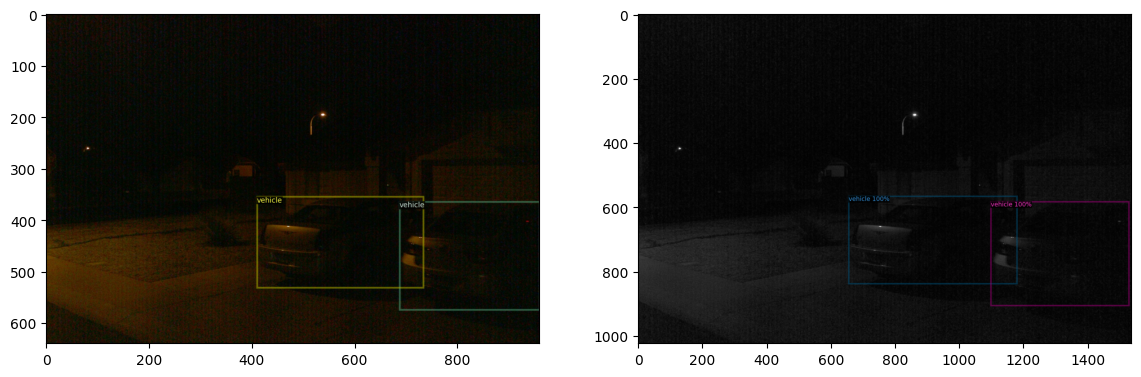

./dataset/test/images/016831.jpg


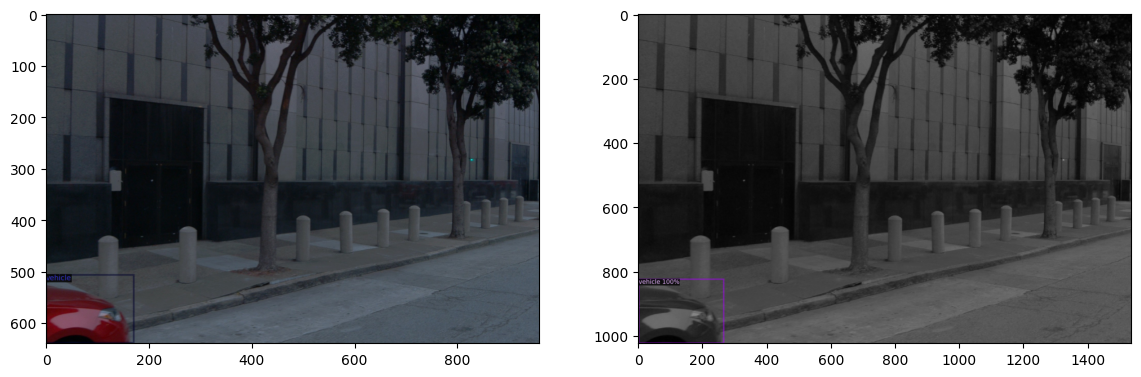

./dataset/test/images/018022.jpg


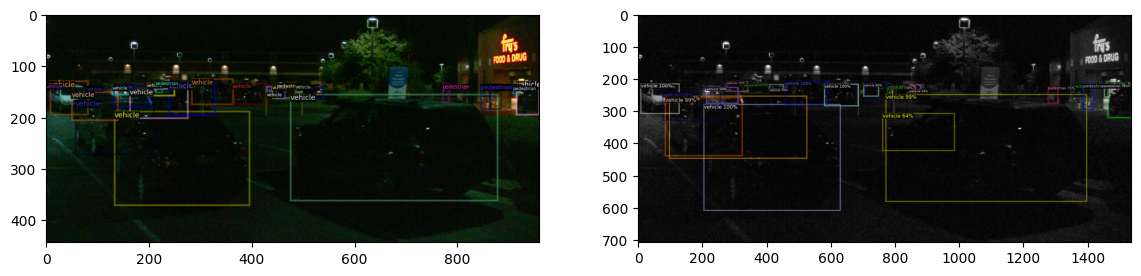

In [14]:
#test data
coco_waymo_test_metadata = MetadataCatalog.get("coco_waymo_test")
dataset_dicts = DatasetCatalog.get("coco_waymo_test")

for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])

    #original validation images
    vi = Visualizer(img[:, :, ::-1], metadata=coco_waymo_test_metadata, scale=0.5)
    out = vi.draw_dataset_dict(d)

    #create plot stuff..
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 10))
    #fig.suptitle("Visualization Originals VS Predictions", fontsize=16)
    ax1.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

    #predictions
    outputs = predictor(img)
    vo = Visualizer(img[:, :, ::-1],
                   metadata=coco_waymo_test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    vo = vo.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax2.imshow(cv2.cvtColor(vo.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

### 2.3.3 COCOEvaluator on Image test dataset

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("coco_waymo_test", output_dir="./output_eval")
val_loader = build_detection_test_loader(cfg, "coco_waymo_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/27 07:33:26 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./coco_annotation/test_annotations.json
[09/27 07:33:26 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  vehicle   | 827          | pedestrian | 336          |    sign    | 0            |
|  cyclist   | 6            |            |              |            |              |
|   total    | 1169         |            |              |            |              |
[09/27 07:33:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/27 07:33:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/27 07:33:26 d2.data.common]: Serializing 100 elements to byte tensors

### 2.3.4 inference from a Video file

In [ ]:
# Create A Video dataset: convert Images to Video 2011_09_26_drive_0005_sync_img3.mp4
'''
import cv2
import numpy as np
import glob
 
img_array = []

for filename in sorted(glob.glob('/test_data/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/*.png')):
    img = cv2.imread(filename)
    filenames.append(filename)
    
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

print(len(img_array))
print(size)

out = cv2.VideoWriter('2011_09_26_drive_0005_sync_img3.mp4',cv2.VideoWriter_fourcc(*'X264'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
'''

In [53]:
pwd

'/home/013907062/CMPE249/HW1'

In [20]:
import atexit
import bisect
import multiprocessing as mp
from collections import deque
import cv2
import torch

from detectron2.data.catalog import Metadata
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer


class VisualizationDemo:
    def __init__(self, cfg, category_names):
        self.metadata = Metadata().set(thing_classes = category_names)
        self.cpu_device = torch.device("cpu")
        self.instance_mode = ColorMode.IMAGE
        self.predictor = DefaultPredictor(cfg)

    def _frame_from_video(self, cap):
        while cap.isOpened():
            success, frame = cap.read()
            if success:
                yield frame
            else:
                break
                
    def run_on_video(self, video):
        video_visualizer = VideoVisualizer(self.metadata, self.instance_mode)
        def process_predictions(frame, predictions):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            predictions = predictions["instances"].to(self.cpu_device)
            vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)
            # Converts Matplotlib RGB format to OpenCV BGR format
            vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
            return vis_frame

        frame_gen = self._frame_from_video(video)
        print("LOG len(frame_gen)", frame_gen)
        
        for frame in frame_gen:
                yield process_predictions(frame, self.predictor(frame))

In [21]:
import tqdm

def detect_video (input, output, category_names, model) :
    #setup configs
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = os.path.join(model)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_names)
    cfg.freeze()

    #setup visualization class
    demo = VisualizationDemo(cfg, category_names)

    cap = cv2.VideoCapture(input)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    vwriter = cv2.VideoWriter(
        filename = output,
        fourcc = cv2.VideoWriter_fourcc(*'mp4v'),
        fps = float(frames_per_second),
        frameSize = (width, height),
        isColor=True)
    
    for vis_frame in tqdm.tqdm(demo.run_on_video(cap), total=num_frames):
        vwriter.write(vis_frame)

    cap.release()
    vwriter.release()

In [22]:
myCategories = ['vehicle','pedestrian','sign','cyclist']
weights = "./OUTPUT_DETECTRON/model_0015999.pth"
inputFile = "2011_09_29_drive_0026_img2.mp4"
outputFile = "output_detectron2_" + inputFile
detect_video(inputFile, outputFile, myCategories, weights)

[09/27 08:12:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./OUTPUT_DETECTRON/model_0015999.pth ...


  0%|                                                                                                         | 0/164 [00:00<?, ?it/s]

LOG len(frame_gen) <generator object VisualizationDemo._frame_from_video at 0x7efb8ebbf220>


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:41<00:00,  3.96it/s]
